![](https://github.com/redwankarimsony/hackerearth-snake-in-the-hood/blob/main/snake%20cover.png)

# Checking for the Good GPU: 
Look for eiter of the Follwoing Two: 
* Tesla P100
* Tesla T4 

## Necessary Tutorials: 
1. [Data Loading Basics](https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c)
2. [Data Loading Advanced](https://www.kdnuggets.com/2019/11/deep-learning-image-classification-less-data.html)
3. [Image classification via fine-tuning with EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)
4. [Basic Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification)
5. [GitHub Project Repo](https://github.com/redwankarimsony/hackerearth-snake-in-the-hood/)
6. [Kaggle Notebook on Flower Classification ](https://www.kaggle.com/serosh/enetb7-512px-no-ensembling)
7. [Convert Data to TFRecords](https://www.tensorflow.org/api_docs/python/tf/data/experimental/TFRecordWriter)






In [ ]:
#check gpu model
from tensorflow.python.client import device_lib
device_lib.list_local_devices()[3]

In [1]:
!pip install -q efficientnet
import efficientnet.tfkeras as efficientnet

#Basic Libraries
import pandas as pd
import numpy as np
import glob, os, shutil, datetime 

# Machine learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter Notebook Utility
from IPython.display import clear_output

# Loading the Old Dataset
!rm -r sample_data
!gdown --id '10h_Gv84nzcqRiOrVFOXGKPbemSyPztqA'
!gdown --id '1MbeY1hOeq7BS7WH9IVr8Ink08dFWDZW1'
!unzip 8a95c26e1bab11eb.zip
!unzip snake_aicrowd_224x224.zip
!rm *.zip
clear_output()

# Processing the Classnames
The original dataframe contains just the `image_id`s where in order to load them in the data pipeline, we need the actual filenames. Hence we will add the file extension `.jpg` with all the `image_id`s. 

In [2]:
train_df = pd.read_csv('/content/dataset/train.csv')
test_df = pd.read_csv('/content/dataset/test.csv')


# Adding Prefix with the image_id
dataset = [train_df, test_df]
for data in dataset: 
    data['image_id'] = [filename + '.jpg' for filename in data['image_id']]

# Producing Class Counts alphabetically
class_counts = train_df['breed'].value_counts()
class_counts = pd.DataFrame({'breed': class_counts.index, 'count': class_counts.values})
class_counts.sort_values(['breed'], inplace = True)
class_counts.reset_index(drop=True)

classes = class_counts['breed'].values.tolist()

# Converting the Data Format. 
For the easier implementation, we will just convert the dataset into a general format of `imagenet format`. 


If you want to use the original format, feel free to change the code and do it by yourself. 

In [3]:
# Creating new train data directory
os.mkdir('dataset_imagenet_format/')

# Creating one folder for each of the image classes. 
for cls in classes:
    os.mkdir('/content/dataset_imagenet_format/' + cls) 

train_dir = '/content/dataset/train/'
new_train_dir = '/content/dataset_imagenet_format/'

# Copying the Train image files to their respective class folders in the training directory.  
for index , row in train_df.iterrows():
    img_path = train_dir + row['image_id']
    dst_path = new_train_dir + row['breed'] + '/' + row['image_id']
    shutil.copy(img_path, dst_path)

# Dataset Loading (by Dataframe) <font color='red'> [Optional]</font>
This part is optional. You can use this or you can simply ignore this. Later on the same data is loaded with default data loader of imagenet format. 

In [4]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Train data loading
train_data = data_generator.flow_from_dataframe(train_df, 
                                                directory='/content/dataset/train',
                                                x_col = 'image_id', 
                                                y_col = 'breed',
                                                target_size = (256,256),
                                                batch_size = 32, 
                                                seed = 42,
                                                shuffle = True, 
                                                class_mode = 'sparse',
                                                subset = 'training')
# Valid Data Loading
valid_data = data_generator.flow_from_dataframe(train_df, 
                                                directory='/content/dataset/train',
                                                x_col = 'image_id', 
                                                y_col = 'breed',
                                                target_size = (256,256),
                                                batch_size = 32, 
                                                seed = 42,
                                                shuffle = True, 
                                                class_mode = 'sparse',
                                                subset = 'validation')

Found 4407 validated image filenames belonging to 35 classes.
Found 1101 validated image filenames belonging to 35 classes.


# Data Loading in <font color='green'> [ImageNet Format]</font>
Here we have few important things. 
1. Dataset downloaded form the **AiCrowd** is used as the training data
2. Original Training data given in Hacker Earth is used as the validation data
3. The test data is the new images that are given with the competition. 

In [5]:
# Dataset Hyperparameters
batch_size = 64
img_height = 128
img_width = 128
train_data_dir = '/content/snake_aicrowd_224x224'
valid_data_dir = '/content/dataset_imagenet_format'
test_data_dir = '/content/dataset/test'
seed = 42

# Train Datagenerator of ImageNet format
train_datagen = ImageDataGenerator(featurewise_center=False, 
                                   samplewise_center=False,
                                   featurewise_std_normalization=False,
                                   samplewise_std_normalization=False,
                                   rotation_range=5,
                                #   width_shift_range=0.2,
                                #   height_shift_range=0.2,
                                #    shear_range=0.1,
                                #    zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                   validation_split=0.2)
# Training Dataset
train_ds = train_datagen.flow_from_directory(train_data_dir,  
                                             subset = 'training',
                                             seed=seed,
                                             class_mode="sparse"  ,
                                             target_size=(img_height, img_width),
                                             batch_size=batch_size)
# Validation Dataset
valid_ds = train_datagen.flow_from_directory(train_data_dir,
                                             subset = 'validation',
                                             seed = seed, 
                                             class_mode="sparse",
                                             target_size=(img_height, img_width),
                                             batch_size=batch_size)

test_datagen = ImageDataGenerator(rescale= 1./255)

# Testing Dataset (from the HackerEarth Dataset's train files)
test_ds1 = test_datagen.flow_from_directory(valid_data_dir,
                                                batch_size=batch_size,
                                                class_mode='sparse',
                                                target_size=(img_height, img_width))
# Dataset for Generating Submissions
test_ds2 = test_datagen.flow_from_dataframe( dataframe = test_df,
                                            directory="/content/dataset/test",
                                            x_col="image_id",
                                            y_col=None,
                                            batch_size = batch_size,
                                            seed=42,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(img_height, img_width))

# Making Class Names and Class Indices
class_maping = train_ds.class_indices
class_names = list(class_maping.keys())
num_classes = len(class_names)

Found 60981 images belonging to 35 classes.
Found 15227 images belonging to 35 classes.
Found 5508 images belonging to 35 classes.
Found 2361 validated image filenames.


# Data Visualization: 
Run the follwoing block of code multiple times to see newer images

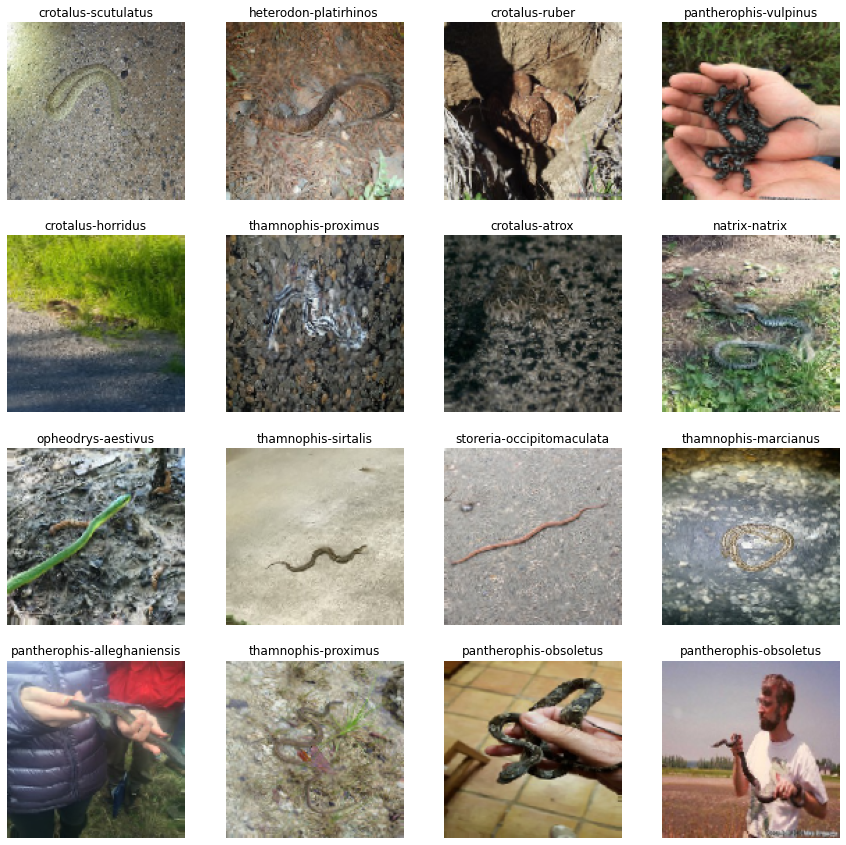

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))

X, y = train_ds.next() 

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[int(y[i])])
    plt.axis("off")

# Crating Callbacks

In [13]:
LR_START = 0.00001
LR_MAX = 0.00005 
LR_MIN = LR_START
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0 # 3
LR_EXP_DECAY = 0.80

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = LR_START + (epoch * (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS)
    elif epoch < (LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS):
        lr = LR_MAX
    else:
        lr = LR_MIN + (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
#    print('For epoch', epoch, 'setting lr to', lr)
    return lr

    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5',
                             save_weights_only=True,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True)

# Model Creation <font color='Green'> [All Model Definitions] </font>

In [19]:
def create_Custom_model():
    # Data Augmentation PipeLine
    data_augmentation = tf.keras.Sequential([RandomFlip("horizontal",
                                                        input_shape=(img_height, img_width,3), 
                                                        name = 'Custom'),
                                            RandomContrast(0.2), 
                                            RandomRotation(0.2),
                                            RandomZoom(0.2)])
    # Model Creation
    model = Sequential([data_augmentation,
                        layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer= 'l2'),
                        layers.BatchNormalization(), 
                        layers.MaxPooling2D(),

                        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer='l2'),
                        layers.BatchNormalization() ,
                        layers.MaxPooling2D(),

                        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer= 'l2'),
                        layers.BatchNormalization(), 
                        layers.MaxPooling2D(),

                        layers.Dropout(0.2),
                        layers.Flatten(),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(num_classes, activation = 'softmax')])

    # Checkpoint for Checking Accuracy
    checkpoint = ModelCheckpoint(filepath='best_weights.hdf5',
                                save_weights_only=True,
                                monitor='val_accuracy',
                                mode='max',
                                save_best_only=True)
    # Model Compilation
    model.compile(optimizer='adam',    
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),    
                metrics=['accuracy'])
    return model


def create_VGG16_model():
    pretrained_model = tf.keras.applications.VGG16(weights = 'imagenet', 
                                                   include_top = False, 
                                                   input_shape=(img_height, img_width,3))
    pretrained_model.trainable = True # False
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
    ])

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

def create_Xception_model():
    pretrained_model = tf.keras.applications.Xception(include_top = False, 
                                                      input_shape=(img_height, img_width,3))
    pretrained_model.trainable = True
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

def create_DenseNet_model():
    pretrained_model = tf.keras.applications.DenseNet201(weights = 'imagenet', 
                                                         include_top = False, 
                                                         input_shape=(img_height, img_width,3))
    pretrained_model.trainable = True
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

def create_EfficientNet_model():
    pretrained_model = efficientnet.EfficientNetB1(weights = 'noisy-student', 
                                                   include_top = False, 
                                                   input_shape=(img_height, img_width,3))
    pretrained_model.trainable = True
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

def create_InceptionV3_model():
    pretrained_model = tf.keras.applications.InceptionV3(weights = 'imagenet', 
                                                         include_top = False, 
                                                         input_shape=(img_height, img_width,3))
    pretrained_model.trainable = True
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

def create_ResNet152_model():
    pretrained_model = tf.keras.applications.ResNet152V2(weights = 'imagenet', 
                                                         include_top = False, 
                                                         input_shape=(img_height, img_width,3))
    pretrained_model.trainable = True
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

def create_MobileNetV2_model():
    pretrained_model = tf.keras.applications.MobileNetV2(weights = 'imagenet', 
                                                         include_top = False, 
                                                         input_shape=(img_height, img_width,3))
    pretrained_model.trainable = True
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

def create_InceptionResNetV2_model():
    pretrained_model = tf.keras.applications.InceptionResNetV2(weights = 'imagenet', 
                                                               include_top = False, 
                                                               input_shape=(img_height, img_width,3))
    pretrained_model.trainable = True
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

# Plotting Training Summary

In [53]:
def plot_train_summary(hist):
    p = hist.history
    acc = []
    loss = []
    for key in p.keys():
        if 'accuracy' in key:
            acc.append(key)
        if 'loss' in key:
            loss.append(key)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(p[acc[0]], label=acc[0], marker = '*', color = 'g')
    plt.plot(p[acc[1]], label=acc[1], marker = '*', color = 'r')
    plt.legend(loc='lower right')
    plt.grid(axis = 'both')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(p[loss[0]], label=loss[0], marker = '*', color = 'g')
    plt.plot(p[loss[1]], label=loss[1], marker = '*', color = 'r')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(axis='both')
    plt.show()

# Training Custom Model

In [41]:
model = create_Custom_model(); model_name = 'CustomModel'
# model = create_VGG16_model()
# model = create_Xception_model()
# model = create_DenseNet_model()
# model = create_EfficientNet_model()
# model = create_InceptionV3_model()
# model = create_ResNet152_model()
# model = create_MobileNetV2_model()
# model = create_InceptionResNetV2_model()

model_name = model.layers[0].name
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1920)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 35)                67235     
Total params: 18,389,219
Trainable params: 18,160,163
Non-trainable params: 229,056
_________________________________________________________________



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
953/953 [==============================] - 454s 476ms/step - loss: 1.6335 - sparse_categorical_accuracy: 0.5253 - val_loss: 1.8170 - val_sparse_categorical_accuracy: 0.4778


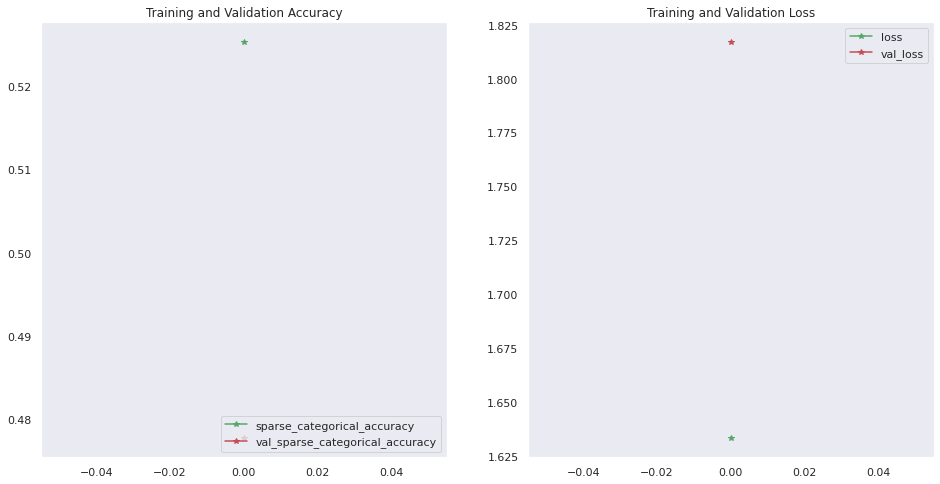

In [58]:
# Training model
hist = model.fit(train_ds,
                 validation_data=valid_ds,
                 epochs=3,
                 callbacks = [lr_callback, checkpoint])

# Plotting the Training Summary
plot_train_summary(hist)

# Submission Generation

In [59]:
# Evaluating Trained Model
print("Evaluating the Second Validaton Set")
[cross_entropy_loss, val_accuracy] = model.evaluate(test_ds1)
[cross_entropy_loss, val_accuracy] 
print('Generating Submission for Unknown Images')
# Predictions for Submissions
preds = model.predict(test_ds2)

Evaluating the Second Validaton Set
87/87 [==============================] - 8s 98ms/step - loss: 1.8544 - sparse_categorical_accuracy: 0.4553
Generating Submission for Unknown Images


In [60]:
sub_df = pd.read_csv('/content/dataset/test.csv')

# TimeStamp of File Generation
ct = datetime.datetime.now() 
timestamp = str(ct.strftime("%Y-%m-%d-%H:%M:%S")) 

# Converting prediction to class index
preds_class_indices = np.array(preds).argmax(axis=1)

# Converting class indices to class names as per submission format
sub_df['breed'] = [classes[class_idx] for class_idx in preds_class_indices]
sub_df.to_csv(f'{timestamp}_{model_name}_submission.csv', index = False)

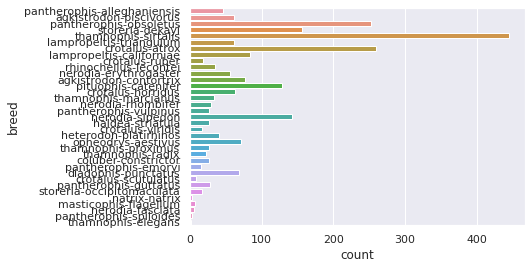

In [61]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(y="breed", data=sub_df)

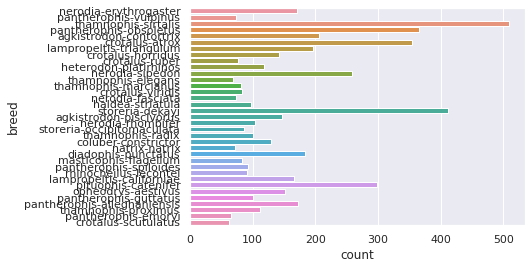

In [ ]:
ax = sns.countplot(y="breed", data=train_df)